In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from plot_learning_curve import plot_learning_curve, plot_validation_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing

None


### Loading and Preprocessing Data

In [2]:
credit_train = pd.read_csv("credit-a.tsv", sep = "\t")
credit_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,2,156,0.000,2,1,13,8,1.25,1,1,1.0,0,0,42,0.0,0
1,1,328,4.460,2,1,11,4,3.04,1,1,6.0,0,0,118,560.0,0
2,1,89,0.500,2,1,11,4,1.50,1,0,0.0,0,0,74,824.0,0
3,2,125,1.540,2,1,13,8,3.75,1,1,5.0,1,0,1,3.0,0
4,2,43,5.625,2,1,13,8,1.71,1,0,0.0,0,2,8,0.0,0


In [3]:
credit_train = pd.get_dummies(credit_train, columns=['A1', 'A4', 'A5', 'A7', 'A9', 'A10', 'A12', 'A13'])
credit_train.shape

(690, 38)

In [4]:
credit_train['target'].value_counts()/credit_train.shape[0]

1    0.555072
0    0.444928
Name: target, dtype: float64

In [5]:
normalize_columns = ['A2', 'A3', 'A6','A8', 'A11', 'A14']
def normalize(columns):
  scaler = preprocessing.StandardScaler()
  credit_train[columns] = scaler.fit_transform(credit_train[columns])
normalize(normalize_columns)

In [6]:
X = credit_train[[c for c in credit_train.columns if c != 'target']]
y = credit_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Trying Boosting Classifier without HyperParameter tunings

In [7]:
base_clf = SVC()

In [8]:
base_clf.fit(X_train, y_train)
y_train_pred = base_clf.predict(X_train)
y_test_pred = base_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.5896737244012495
Test Accuracy:  0.6695652173913044


In [9]:
base_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Generate Learning Curve & Validation Curve with default classifier

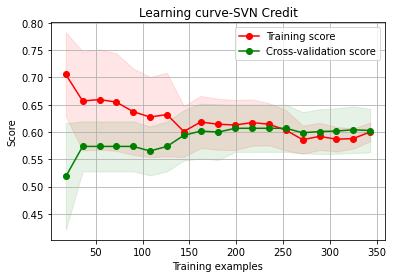

In [10]:
plot_learning_curve(base_clf, "Learning curve-SVN Credit", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

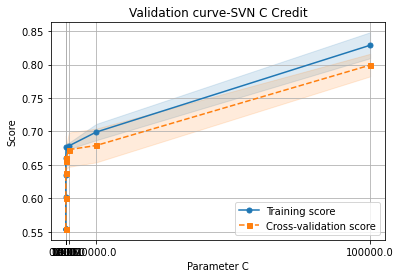

In [11]:
plot_validation_curve(base_clf, X_train, y_train, 'C', np.logspace(-5, 5, 11), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-SVN C Credit")

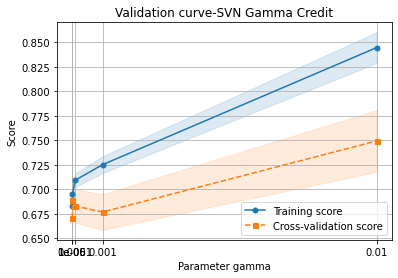

In [12]:
plot_validation_curve(base_clf, X_train, y_train, 'gamma', [0.000001, 0.00001, 0.0001, 0.001, 0.01], cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-SVN Gamma Credit")

### Conducting GridSearch to obtain best HyperParameters

In [13]:
param_grid = {
    'C': np.logspace(-5, 5, 11), 
    #'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf']
}

In [14]:
grid_search = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 11 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0349s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0658s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 out of  44 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of  44 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.3s finished


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'kernel': ['rbf']},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [15]:
grid_search.best_params_

{'C': 100000.0, 'kernel': 'rbf'}

In [16]:
grid_search.best_estimator_

SVC(C=100000.0)

In [17]:
grid_search.best_score_

0.7922807346913232

### Generating Learning Curve with tuned Hyperparameters

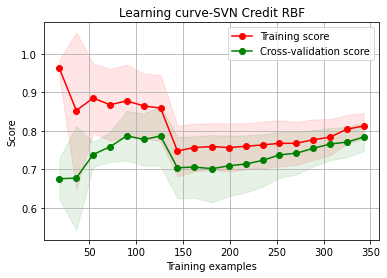

In [18]:
plot_learning_curve(grid_search.best_estimator_, "Learning curve-SVN Credit RBF", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

In [ ]:
#plot_validation_curve(SVC(kernel='poly', gamma="auto"), X_train, y_train, 'degree', [1,2,3,4,5,6,7,8,9,10,11,12,13], cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-SVN degree Poly Credit")

In [15]:
param_grid = {
    'C': np.logspace(-5, 5, 11), 
    #'gamma': [1,0.1,0.01,0.001],
    'kernel': ['poly'],
    'degree': [1,2,3,4,5]
}

In [16]:
grid_search = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 55 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0349s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0668s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1381s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    4.5s finished


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'degree': [1, 2, 3, 4, 5], 'kernel': ['poly']},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [17]:
grid_search.best_params_

{'C': 100000.0, 'degree': 1, 'kernel': 'poly'}

In [18]:
grid_search.best_estimator_

SVC(C=100000.0, degree=1, kernel='poly')

In [19]:
grid_search.best_score_

0.7727654964172846

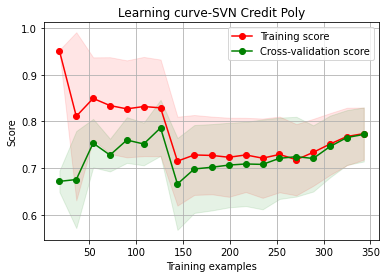

In [20]:
plot_learning_curve(grid_search.best_estimator_, "Learning curve-SVN Credit Poly", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

### Fitting classifier with best parameters and calculating test score

In [22]:
best_clf = SVC(C=100000.0)
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.8570374869836863
Test Accuracy:  0.8597826086956522


In [23]:
best_clf = SVC(C=100000.0, degree=1, kernel='poly')
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.815229087122527
Test Accuracy:  0.8619565217391304
